<a href="https://colab.research.google.com/github/neohack22/IASD/blob/IA/IA/projects/robustness/Notebook_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()

In [1]:
import json
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

cuda = torch.cuda.is_available()

## Moving to neural networks

Now that we've seen how adversarial examples work in the context of linear models, let's move to the setting we really care about: the possibility of adversarial examples in deep neural networks. 

First, let us define formally a neural network. Let us define $h_\theta(x) : \mathbb{R}^n \rightarrow \mathbb{R}^k$ to be an $d$-layer network, given by the following equations
\begin{equation}
\begin{split}
z_1 & = x \\
z_{i+1} & = f_i(W_i z_i + b_i), \;\; i,\ldots,d \\
h_\theta(x) & = z_{d+1}
\end{split}
\end{equation}
where $z_i$ denote the activations at layer $i$; $f_i$ denotes the activation function for layer $i$, which we will often take to be e.g. the ReLU operator $f_i(z) = \max\{0,z\}$ for layers $i=1,\ldots,d-1$ and the linear operator $f_i(z) = z$ for layer $d$ (remember, the last layer outputs are the class logits, and the loss function "builds in" the softmax operator, so we don't explicitly put the softmax into the network); and the parameters of the network are given by $\theta = \{W_1,b_1,\ldots,W_d,b_d\}$ (in the above, $W_i$ is most obviously interpreted a matrix, but it could really be any linear operator including convolutions).  We won't worry for now about explicitly defining the size of all the intermediate layers, but we assume that they are specified such that the final function $h_\theta$ takes inputs in $\mathbb{R}^n$ and outputs vectors in $\mathbb{R}^k$.  The loss function for multiclass case, namely the Cross Entropy loss, is as follows:
\begin{equation}
\ell(h_\theta(x), y) = \log \left ( \sum_{j=1}^k \exp(h_\theta(x)_j) \right ) - h_\theta(x)_y.
\end{equation}

## Crafting an attack

Unlike it the linear case, it is _not_ easy to solve, the maximization problem over our perturbation. This is because the cost surface for neural networks (here considering it over the _input_ space, not parameter space) is not convex, and is especially prone to local optima.  We can see this even in the simple example above, where there are local optimal when either trying to maximize or minimize the function above, and the initial gradient at a given point may or may not point in the direction of the actual maxima. 

So how _do_ we go about (approximately) solving the inner optimization problem
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y)
\end{equation}
in the case of $h_\theta$ being a neural network? 

The most common strategy to approximate the pertubation is to find a _lower bound_ on the optimization objective.  Because (by definition) _any_ feasible $\delta$ will give us a lower bound, this is equivalent to just "trying to empirically solve the optimization problem", i.e., "find an adversarial example."  
This is by far the most common strategy for solving the inner maximization motivated largely by the fact that for neural networks in general, problems of local optima don't seem as bad as initially may be thought. 

## Lower bounding the inner maximization (i.e., adversarial attacks)

Let's start by considering perhaps the simplest way of solving the optimization problem we care about, the task of maximizing
\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(h_\theta(x + \delta), y).
\end{equation}
In fact we already saw one example for how to do this in our introductory lecture, but the basic idea here is quite simple: using backpropagation, we can compute the gradient of the loss function with respect to the perturbation $\delta$ itself, so let's just perform gradient descent on $\delta$ to maximize our objective.  However, we also need to ensure that $\delta$ stays within the norm bound $\epsilon$, so after each step, we can project back into this space.



### The Fast Gradient Sign Method (FGSM)

Let's consider in a bit more detail how we might do the attack we mentioned above.  For some given example $x$, we know that we are going to adjust $\delta$ in the direction of it's gradient, i.e., we will first compute the gradient
\begin{equation}
g := \nabla_\delta \ell(h_\theta(x + \delta),y)
\end{equation}
using simple backpropagation; note that if we're evaluating this gradient at $\delta=0$ (as we would at the first timestep), then this is also just equal to $\nabla_x \ell(h_\theta(x),y)$, but we'll express the gradients in terms of $\delta$ to be consistent with how we do things going forward.

In order to maximize loss, we want to adjust delta in the direction of this gradient, i.e., take a step
\begin{equation}
\delta := \delta + \alpha g
\end{equation}
for some step size $\alpha$ and then project back into the norm ball defined by $\|\delta\| \leq \epsilon$.  But how big a step do we take?  For concreteness, let's consider the particular case of the $\ell_\infty$ norm $\|\delta\|_\infty \leq \epsilon$, where, as we mentioned before, projecting onto this norm ball simply involves clipping values of $\delta$ to lie within the range $[-\epsilon, \epsilon]$.  If our initial $\delta$ is zero, this gives the update
\begin{equation}
\delta := \mathrm{clip}(\alpha g, [-\epsilon, \epsilon]).
\end{equation}
Now, how big of a step size should we take?  If we want to make increase the loss as much as possible, it makes sense to take as large a step as possible, i.e., take $\alpha$ to be very large (of course knowing that we won't take _that_ big a step, since we're projecting back into the $\ell_\infty$ ball afterwards).  It is not hard to see that for $\alpha$ large enough, the relative sizes of the entries of $g$ won't matter: we will simply take $\delta_i$ to be either $+\epsilon$ or $-\epsilon$ depending upon the sign of $g_i$.  In other words, for large $\alpha$, this update becomes
\begin{equation}
\delta := \epsilon \cdot \mathrm{sign}(g).
\end{equation}

This is know as the Fast Gradient Sign Method (FGSM) [1], and it was one of the first methods for constructing adversarial examples proposed by the deep learning community.

[1] Explaining and Harnessing Adversarial Examples

### Exercice 2
1. Define a neural network with 3 fully connected layers
2. Define a neural network with 2 convolutional layers and a last fully connected layer
2. Train the network on the full MNIST Dataset
3. Code the FGSM attack
4. Evaluate your model against FGSM
5. Plot some images with and without the adversarial perturbation
6. Make an analysis of FGSM attack and compare it with the attack from the first notebook

In [ ]:
#@title
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10("./docs", train=split, download=True, transform=transforms.ToTensor())
  return DataLoader(dataset, batch_size=batch_size, shuffle=train)

batch_size = 100
train_loader = load_cifar('train', batch_size)
test_loader = load_cifar('test', batch_size)

In [2]:
# load CIFAR10 dataset
def load_cifar(split, batch_size):
  train = True if split == 'train' else False
  dataset = datasets.CIFAR10(
      "./docs", train=split, download=True, transform=transforms.ToTensor()
  )
  return DataLoader(
      dataset, batch_size=batch_size, shuffle=train
  )

batch_size = 100
train_loader = load_cifar(
    'train', batch_size
)
test_loader = load_cifar(
    'test', batch_size
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./docs/cifar-10-python.tar.gz to ./docs
Files already downloaded and verified


In [4]:
#@title
def train_model(model, criterion, optimizer, loader):
  """Function to train the model"""
    if cuda:
        imgs, labels = imgs.cuda(), labels.cuda()
  # code here ...
  epochs = 10
  iter = 0
  for epoch in range(int(
          epochs
      )):
    for batch_n, (
        imgs = Variable(
            images.view(
                -1, 28 * 28
            )
        )
        labels = Variable(labels)

        opt.zero_grad() #opt #zero_grad()
        outputs = model( # model()
            imgs
        )
        loss.backward() # loss # backward()
        opt.step() # step()

        iter+=1
    )



IndentationError: ignored

In [5]:
def train_model(model, criterion, optimizer, loader):
  """Function to train the model"""
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
    epochs = 10
    iter = 0
    for epoch in range(int(epochs)):
      for batch_n, (imgs = Variable(images.view(-1, 28 * 28))
      labels = Variable(labels)
      
      opt.zero_grad()
      outputs = model(imgs)
      loss.backward()
      opt.step()
      iter+=1)

SyntaxError: ignored

In [ ]:
&# convolutional model with 2 convolution, 2 max pooling layer, 3 fully connected layer
# the model should be: 2x (conv -> max pooling -> relu) -> 2x (fc -> relu) -> fc

class ConvModel(torch.nn.Module):
  
  def __init__(self):
    super(ConvModel, self).__init__()
    # code here ...
    self.fc1 = nn.Linear(16, 12)
    self.fc2 = nn.Linear(12, 10)
    self.fc3 = nn.Linear(10, 1)

  
  def forward(self, x):
    # code here ...
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)

model = ConvModel()    

criterion = torch.nn.CrossEntropyLoss()    

In [ ]:
model = ConvModel()
if cuda:
  model = model.cuda()

# define your loss function
criterion = # code here ...

# define your optimizer
opt = # code here ...

train_model(model, criterion, opt, train_loader)

In [ ]:
def eval_model(model, loader, attack=None):
  """Function to evaluate your model on a specific loader"""
    if cuda:
        imgs, labels = imgs.cuda(), labels.cuda()
  # code here ...

eval_model(model, test_loader)

In [ ]:
class FastGradientSignMethod:
  
  def __init__(self, model, eps):
    # code here ...
  
  def compute(self, x, y):
    """ Construct FGSM adversarial perturbation for examples x"""
    # code here ...

opt = torch.optim.SGD( #optim
    model.parameters(), lr=lr_rate # lr_rate
)

fgsm = # code here ...
eval_model(model, test_loader, fgsm)

In [ ]:
def plot_images(x, y, yp, M=5, N=5):
  x = x.cpu().numpy()
  y = y.cpu().numpy()
  f, ax = plt.subplots(M, N, sharex=True, sharey=True, figsize=(N, M*1.3))
  for i in range(M):
    for j in range(N):
      img = x[i*N+j].transpose(1, 2, 0)
      img = np.maximum(0, np.minimum(img, 1))
      ax[i][j].imshow(img)
      title = ax[i][j].set_title("Pred: {}".format(yp[i*N+j].max(dim=0)[1]))
      plt.setp(title, color=('g' if yp[i*N+j].max(dim=0)[1] == y[i*N+j] else 'r'))
      ax[i][j].set_axis_off()
    plt.tight_layout()
  plt.show()
  
for imgs, labels in test_loader:
  if cuda:
    imgs, labels = imgs.cuda(), labels.cuda()
  break

# plot natural images
output = model(imgs)
plot_images(imgs, labels, output)
  
# plot adversarial images
delta = fgsm.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs + delta, labels, output)

### Projected gradient descent

This discussion immediately brings us to the next approach we would want to consider for maximizing the optimization problem, just doing projected gradient descent (i.e., the above procedure, but iterating it and with a smaller step size). [Note: technically speaking, this is gradient _ascent_ since we are maximizing a function rather than minimization, but it's common to just refer to the process as gradient descent.]. This was also called the "basic iterative procedure" in it's first appearance within the adversarial attacks literature [1], but essentially it is just the obvious choice for how we might maximize the inner objective a bit more carefully than with FGSM. The basic PGD algorithm simply iterates the updates:
\begin{equation}
\begin{split}
& \mbox{Repeat:} \\
& \quad \delta := \mathcal{P}(\delta + \alpha \nabla_\delta \ell(h_\theta(x+\delta), y))
\end{split}
\end{equation}
where $\mathcal{P}$ denotes the projection onto the ball of interest (for example, clipping in the case of the $\ell_\infty$ norm).  Of course, with PGD we now have more choices we need to make when specifying the attack, such as the actual stepsize itself, and the number of iterations (we'll discuss some rules of thumb shortly once we present a slightly modified version of the above iteration).  We can implement this attack in the following manner, where we're here going to implement the gradient descent procedure rather than rely on one of PyTorch's optimizers, as we want to see what's going on a bit more explicitly (PyTorch's SGD also includes terms like momentum, which actually usually are able to optimize the inner term _better_, but we want to have as little black-box procedures here as possible).

[1] Adversarial Machine Learning At Scale

In [ ]:
class ProjectedGradientDescent:
  
  def __init__(self, model, eps, alpha, num_iter):
    # code here ...
  
  def compute(self, x, y):
    """ Construct PGD adversarial pertubration on the examples x."""  
    # code here ...


pgd = # code here ...
eval_model(model, test_loader, pgd)

In [ ]:
pgd = # code here ...
delta = pgd.compute(imgs, labels)
output = model(imgs + delta)
plot_images(imgs+delta, labels, output)

In [ ]:
### Test you attacks on real world images

In [ ]:
let's use the (pre-trained) ResNet50 model within PyTorch to classify this picture of a pig.

!['Pig'](docs/pig.jpg)

The normal strategy for image classification in PyTorch is to first transform the image (to approximately zero-mean, unit variance) using the `torchvision.transforms` module.  However, because we'd like to make perturbations in the original (unnormalized) image space, we'll take a slightly different approach and actually build the transformations at PyTorch layers, so that we can directly feed the image in.  First, let's just load the image and resize the 224x224, which is the default size that most ImageNet images (and hence the pre-trained classifiers) take as input.

In [ ]:
# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("docs/pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))
plt.show()

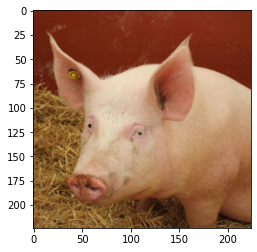

In [ ]:
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();

In [ ]:
# form predictions
pred = model(norm(pig_tensor))

In [ ]:
# attack the pig image and plot the perturbation